# Online Convex Optimization

In this notebook, we present the different algorithm implemented in this repository and compare them. Hyperparameters can be tuned globally for all the algorithms at the same time or individually, in each algorithm's own cell. This setup allows quick and easy comparison and can be used to experiment interractively with the different algoritms.

### Imports

In [1]:
import time
import numpy as np
import pandas as pd
import pathlib as Path
import seaborn as sns

In [2]:
from Algorithms.Adam import adamax, adamax_temporal, adam, adam_p, adam_temporal, adam_proj
from Algorithms.Explo import sbeg, sreg
from Algorithms.GD import gd, projected_gd
from Algorithms.SGD import sgd, projected_sgd
from Algorithms.RFTL import adagrad, seg, smd
from Algorithms.ONS import ons
from Models.LinearSVM import LinearSVM
from utils import *

### Default Parameters
The default parameters for the algorithms. It can be particularized later in each specific algorithm block.

In [5]:
np.random.seed(123)

lr = 0.1
nepoch = 1000
lbd = 1/3
z = 100
gamma = 1/8
verbose = 100

### Initialization
We start with loading and normalizing the data. We only conduct binary classification so we label images of zeros from MNIST as 1 and every other labels as -1.

Ready!


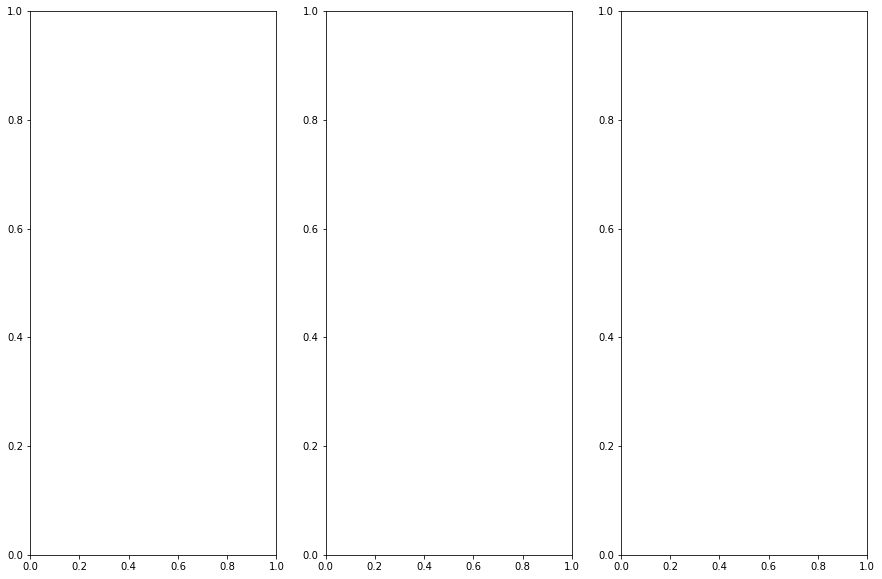

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

mnist_train = pd.read_csv('mnist_train.csv', sep=',', header=None)   # Reading
# Extract data
train_data = mnist_train.values[:, 1:]
# Normalize data
train_data = train_data / np.max(train_data)
train_data = np.c_[train_data, np.ones(train_data.shape[0])]         # Add intercept
# Extract labels
train_labels = mnist_train.values[:, 0]
# if labels is not 0 => -1 (Convention chosen)
train_labels[np.where(train_labels != 0)] = -1
# if label is 0 ==> 1
train_labels[np.where(train_labels == 0)] = 1

mnist_test = pd.read_csv('mnist_test.csv', sep=',', header=None)
test_data = mnist_test.values[:, 1:]
test_data = test_data / np.max(test_data)
test_data = np.c_[test_data, np.ones(test_data.shape[0])]
test_labels = mnist_test.values[:, 0]
test_labels[np.where(test_labels != 0)] = -1
test_labels[np.where(test_labels == 0)] = 1

time_dict = {}

n, m = train_data.shape
print('Ready!')

### Gradient Descent 

In [ ]:
print("-----------GD----------- \n")
model = LinearSVM(m)
tic = time.time()

GDloss, wts = gd(model, train_data, train_labels, nepoch, lbd, verbose, lr)
time_dict['gd'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
GDacc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, Unconstrained GD algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, GDloss[-1], GDacc))

ax[0].plot(np.arange(nepoch), GDloss, label = 'gd')
GDaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(GDaccuracies, label = 'gd')
GDerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(GDerrors, label = 'gd')

### Constrained Gradient Descend
Gradient Descent with projection on $B_1(z)$

In [ ]:
print("-----------c_GD - z="+str(z)+"----------- \n")
model = LinearSVM(m)
tic = time.time()

GDprojloss, wts = projected_gd(model, train_data, train_labels, nepoch, lbd, z, verbose, lr)
time_dict['c_gd z='+str(z)] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
GDacc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained GD (radius {:3d}) algorithm has a losof {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, GDprojloss[-1], GDacc))

ax[0].plot(np.arange(nepoch), GDprojloss, label = 'c_gd z='+str(z))
GDprojaccuracies = compute_accuracies(wts, test_data, test_labels, average=False)  # no average for gd
ax[1].plot(GDprojaccuracies, label = 'c_gd z='+str(z))
GDprojerrors = compute_errors(wts, test_data, test_labels, average=False)
ax[2].plot(GDprojerrors,label = 'c_gd z='+str(z))

### Stochastic Gradient Descent 

In [8]:
print("-----------SGD----------- \n")
model = LinearSVM(m)
tic = time.time()

SGDloss, wts = sgd(model, train_data, train_labels, nepoch, lbd, verbose, 1)
time_dict['sgd'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, Unconstrained SGD algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SGDloss[-1], acc))

ax[0].plot(np.arange(nepoch), SGDloss, label = 'sgd')
SGDaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SGDaccuracies, label = 'sgd')
SGDerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SGDerrors, label = 'sgd')

-----------SGD----------- 

Epoch   0 : Loss = 194.6494
Epoch 100 : Loss = 0.1990
Epoch 200 : Loss = 0.1739
Epoch 300 : Loss = 0.2246
Epoch 400 : Loss = 0.1668
Epoch 500 : Loss = 0.1923
Epoch 600 : Loss = 0.1590
Epoch 700 : Loss = 0.1556
Epoch 800 : Loss = 0.1636
Epoch 900 : Loss = 0.1605
After 1000 epoch, Unconstrained SGD algorithm has a loss of 0.176836 and accuracy 0.965300


### Constrained Stochastic Gradient Descent
Stochastic Gradient Descent with projection on $B_1(z)$

In [9]:
print("-----------c_SGD - z=" + str(z)+"----------- \n")
model = LinearSVM(m)
tic = time.time()

SGDprojloss, wts = projected_sgd(model, train_data, train_labels, nepoch, lbd, z, verbose, 1)
time_dict['c_sgd z='+str(z)] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SGD (radius {:3d}) algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, SGDprojloss[-1], acc))

ax[0].plot(np.arange(nepoch), SGDprojloss, label = 'c_sgd z='+str(z))
SGDprojaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SGDprojaccuracies, label = 'c_sgd z='+str(z))
SGDprojerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SGDprojerrors, label = 'c_sgd z='+str(z))

-----------c_SGD - z=100----------- 

Epoch   0 : Loss = 27.2007
Epoch 100 : Loss = 0.3793
Epoch 200 : Loss = 0.1907
Epoch 300 : Loss = 0.1759
Epoch 400 : Loss = 0.1979
Epoch 500 : Loss = 0.1620
Epoch 600 : Loss = 0.1499
Epoch 700 : Loss = 0.1510
Epoch 800 : Loss = 0.1585
Epoch 900 : Loss = 0.1513
After 1000 epoch, constrained SGD (radius 100) algorithm has a loss of 0.150311 and accuracy 0.969400


### Stochastic Miror Descent (SMD)

In [10]:
model = LinearSVM(m)
tic = time.time()

SMDprojloss, wts = smd(model, train_data, train_labels, nepoch, lbd, z, lr, verbose)
time_dict['smd'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SMD algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SMDprojloss[-1], acc))

ax[0].plot(np.arange(nepoch), SMDprojloss, label = 'smd')
SMDprojaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SMDprojaccuracies, label = 'smd')
SMDprojerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SMDprojerrors, label = 'smd')

Epoch   0 : Loss = 0.8523
Epoch 100 : Loss = 0.3002
Epoch 200 : Loss = 0.2073
Epoch 300 : Loss = 0.1863
Epoch 400 : Loss = 0.1832
Epoch 500 : Loss = 0.1651
Epoch 600 : Loss = 0.1620
Epoch 700 : Loss = 0.1627
Epoch 800 : Loss = 0.1550
Epoch 900 : Loss = 0.1530
After 1000 epoch, constrained SMD algorithm has a loss of 0.148531 and accuracy 0.971400


### Stochastic Exponential Gradient (SEG)

In [11]:
print("-----------SMD----------- \n")
model = LinearSVM(m)
tic = time.time()

SEGloss, wts = seg(model, train_data, train_labels, nepoch, lbd, z, 1, verbose)
time_dict['seg'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SEG algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SEGloss[-1], acc))

ax[0].plot(np.arange(nepoch), SEGloss, label = 'seg')
SEGaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SEGaccuracies, label = 'seg')
SEGerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SEGerrors, label = 'seg')

-----------SMD----------- 

Epoch   0 : Loss = 1.0189
Epoch 100 : Loss = 0.2400
Epoch 200 : Loss = 0.2254
Epoch 300 : Loss = 0.2324
Epoch 400 : Loss = 0.1961
Epoch 500 : Loss = 0.1665
Epoch 600 : Loss = 0.1580
Epoch 700 : Loss = 0.1750
Epoch 800 : Loss = 0.1544
Epoch 900 : Loss = 0.1512
After 1000 epoch, constrained SEG algorithm has a loss of 0.150959 and accuracy 0.975100


### Adaptative Gradient (Adagrad)

In [12]:
print("-----------Adagrad - z=" + str(z)+"----------- \n")
model = LinearSVM(m)
tic = time.time()

Adagradloss, wts = adagrad(model, train_data, train_labels, nepoch, lbd, z, 1, verbose)
time_dict['adagrad'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained Adagrad (radius {:3d}) algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, Adagradloss[-1], acc))

ax[0].plot(np.arange(nepoch), Adagradloss, label = 'adagrad z='+str(z))
Adagradaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(Adagradaccuracies, label = 'adagrad z='+str(z))
Adagraderrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(Adagraderrors,  label = 'adagrad z='+str(z))

-----------Adagrad - z=100----------- 

Epoch   0 : Loss = 9.5579
Epoch 100 : Loss = 3.8773
Epoch 200 : Loss = 1.6242
Epoch 300 : Loss = 1.8637
Epoch 400 : Loss = 4.5524
Epoch 500 : Loss = 4.5957
Epoch 600 : Loss = 0.4461
Epoch 700 : Loss = 1.1928
Epoch 800 : Loss = 1.1888
Epoch 900 : Loss = 0.4264
After 1000 epoch, constrained Adagrad (radius 100) algorithm has a loss of 0.639606 and accuracy 0.948900


### Online Newton Step (ONS)

In [13]:
print("-----------ONS - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

ONSloss, wts = ons(model, train_data, train_labels, nepoch, lbd, gamma, z, 1, verbose)
time_dict['ons'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, ONS (radius {:3d} algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, ONSloss[-1], acc))

ax[0].plot(np.arange(nepoch), ONSloss,  label = 'ons z='+str(z))
ONSaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(ONSaccuracies,  label = 'ons z='+str(z))
ONSerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(ONSerrors,  label = 'ons z='+str(z))

-----------ONS - z=100----------- 

Epoch   0 : Loss = 0.6323
Epoch 100 : Loss = 0.5657
Epoch 200 : Loss = 0.2759
Epoch 300 : Loss = 1.0639
Epoch 400 : Loss = 0.6102
Epoch 500 : Loss = 0.6120
Epoch 600 : Loss = 0.5149
Epoch 700 : Loss = 0.7027
Epoch 800 : Loss = 0.7562
Epoch 900 : Loss = 1.6296
After 1000 epoch, ONS (radius 100 algorithm has a loss of 0.636392 and accuracy 0.955000


### SREG

In [14]:
print("-----------SREG - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

SREGloss, wts = sreg(model, train_data, train_labels, nepoch, lbd, z, 1, verbose)
time_dict['sreg'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SREG (radius {:3d}) algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, z, SREGloss[-1], acc))

ax[0].plot(np.arange(nepoch), SREGloss, label = 'sreg z='+str(z))
SREGaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SREGaccuracies, label = 'sreg z='+str(z))
SREGerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SREGerrors, label = 'sreg z='+str(z))

-----------SREG - z=100----------- 

Epoch   0 : Loss = 2.6774
Epoch 100 : Loss = 1523.8197
Epoch 200 : Loss = 1524.0189
Epoch 300 : Loss = 1659.3941
Epoch 400 : Loss = 1659.3168
Epoch 500 : Loss = 1659.1998
Epoch 600 : Loss = 1698.3116
Epoch 700 : Loss = 1698.3116
Epoch 800 : Loss = 1698.3116
Epoch 900 : Loss = 1698.3116
After 1000 epoch, constrained SREG (radius 100) algorithm has a loss of 1698.311586 and accuracy 0.739600


### SBEG

In [15]:
print("-----------SBEG - z=" + str(z) + "----------- \n")
model = LinearSVM(m)
tic = time.time()

SBEGloss, wts = sbeg(model, train_data, train_labels, nepoch, lbd, z, 1, verbose)
time_dict['sbeg'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, constrained SBEG algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, SBEGloss[-1], acc))

ax[0].plot(np.arange(nepoch), SBEGloss, label = 'sbeg z='+str(z))
SBEGaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(SBEGaccuracies, label = 'sbeg z='+str(z))
SBEGerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(SBEGerrors, label = 'sbeg z='+str(z))

-----------SBEG - z=100----------- 

Epoch   0 : Loss = 50.3302
Epoch 100 : Loss = 1.1895
Epoch 200 : Loss = 0.5598
Epoch 300 : Loss = 0.5192
Epoch 400 : Loss = 0.5093
Epoch 500 : Loss = 0.4592
Epoch 600 : Loss = 0.4504
Epoch 700 : Loss = 0.4477
Epoch 800 : Loss = 0.5739
Epoch 900 : Loss = 0.5703
After 1000 epoch, constrained SBEG algorithm has a loss of 0.512172 and accuracy 0.902700


### Adam

In [16]:
lr = 0.003
betas = [0.9, 0.999]

In [17]:
print("-----------Adam ----------- \n")
model = LinearSVM(m)
tic = time.time()

Adamloss, wts = adam(model, train_data, train_labels, lr, nepoch, lbd, betas, verbose)
time_dict['adam'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, Adamloss[-1], acc))

ax[0].plot(np.arange(nepoch), Adamloss, label='adam')
Adamaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(Adamaccuracies, label='adam')
Adamerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(Adamerrors, label='adam')

-----------Adam ----------- 

Epoch   0 : Loss = 0.9692
Epoch 100 : Loss = 0.2649
Epoch 200 : Loss = 0.2089
Epoch 300 : Loss = 0.1682
Epoch 400 : Loss = 0.1650
Epoch 500 : Loss = 0.2033
Epoch 600 : Loss = 0.1537
Epoch 700 : Loss = 0.1994
Epoch 800 : Loss = 0.1787
Epoch 900 : Loss = 0.1845
After 1000 epoch, adam algorithm has a loss of 0.158112 and accuracy 0.975300


### Adam Fixed LR

In [18]:
model = LinearSVM(m)
tic = time.time()

AdamLRloss, wts = adam(model, train_data, train_labels, lr, nepoch, lbd, betas, verbose, adaptative_lr=False)
time_dict['adam_fixlr'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam with fixed lr algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdamLRloss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamLRloss, label = 'adam_fixlr')
AdamLRaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamLRaccuracies, label = 'adam_fixlr')
AdamLRerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamLRerrors, label = 'adam_fixlr')

Epoch   0 : Loss = 0.9178
Epoch 100 : Loss = 0.2044
Epoch 200 : Loss = 0.1762
Epoch 300 : Loss = 0.1568
Epoch 400 : Loss = 0.1982
Epoch 500 : Loss = 0.1638
Epoch 600 : Loss = 0.1882
Epoch 700 : Loss = 0.1949
Epoch 800 : Loss = 0.1812
Epoch 900 : Loss = 0.2735
After 1000 epoch, adam with fixed lr algorithm has a loss of 0.216158 and accuracy 0.967200


### Adam Projected

In [19]:
model = LinearSVM(m)
tic = time.time()

AdamProjloss, wts = adam_proj(model, train_data, train_labels, lr, nepoch, lbd, z, betas, verbose)
time_dict['adamproj'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, projected adam algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdamProjloss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamProjloss, label = 'adamproj')
AdamProjaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamProjaccuracies, label = 'adamproj')
AdamProjerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamProjerrors, label = 'adamproj')

Epoch   0 : Loss = 0.9926
Epoch 100 : Loss = 0.2276
Epoch 200 : Loss = 0.1937
Epoch 300 : Loss = 0.1713
Epoch 400 : Loss = 0.2465
Epoch 500 : Loss = 0.1709
Epoch 600 : Loss = 0.1801
Epoch 700 : Loss = 0.3645
Epoch 800 : Loss = 0.2392
Epoch 900 : Loss = 0.1915
After 1000 epoch, projected adam algorithm has a loss of 0.176788 and accuracy 0.970700


### Adamp

In [20]:
p = 3

model = LinearSVM(m)
tic = time.time()

AdamPloss, wts = adam_p(model, train_data, train_labels, lr, nepoch, lbd, betas, p, verbose)
time_dict['adamp'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam with norm L{:3d} algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, p, AdamPloss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamPloss, label = 'adamp')
AdamPaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamPaccuracies, label = 'adamp')
AdamPerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamPerrors, label = 'adamp')

Epoch   0 : Loss = 0.9223
Epoch 100 : Loss = 0.2103
Epoch 200 : Loss = 0.1783
Epoch 300 : Loss = 0.1739
Epoch 400 : Loss = 0.1751
Epoch 500 : Loss = 0.1706
Epoch 600 : Loss = 0.1528
Epoch 700 : Loss = 0.1687
Epoch 800 : Loss = 0.1928
Epoch 900 : Loss = 0.1640
After 1000 epoch, adam with norm L  3 algorithm has a loss of 0.164917 and accuracy 0.973800


### Adam Temp

In [21]:
model = LinearSVM(m)
tic = time.time()

AdamTemploss, wts = adam_temporal(model, train_data, train_labels, lr, nepoch, lbd, betas, verbose)
time_dict['adamtemp'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, adam with temporal averaging algorithm has a loss of{:1.6f} and accuracy {:1.6f}'.format(nepoch, AdamTemploss[-1], acc))

ax[0].plot(np.arange(nepoch), AdamTemploss, label = 'adamtemp')
AdamTempaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdamTempaccuracies, label = 'adamtemp')
AdamTemperrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdamTemperrors, label = 'adamtemp')

Epoch   0 : Loss = 0.9000
Epoch 100 : Loss = 0.3556
Epoch 200 : Loss = 0.3299
Epoch 300 : Loss = 0.2767
Epoch 400 : Loss = 0.2768
Epoch 500 : Loss = 0.2441
Epoch 600 : Loss = 0.2692
Epoch 700 : Loss = 0.2032
Epoch 800 : Loss = 0.3142
Epoch 900 : Loss = 0.3019
After 1000 epoch, adam with temporal averaging algorithm has a loss of0.184024 and accuracy 0.968500


### Adamax

In [22]:
model = LinearSVM(m)
tic = time.time()

AdaMaxLoss, wts = adamax(model, train_data, train_labels, lr, nepoch, lbd, betas, verbose)
time_dict['adamax'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, AdaMax algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdaMaxLoss[-1], acc))

ax[0].plot(np.arange(nepoch), AdaMaxLoss, label = 'adamax')
AdaMaxaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdaMaxaccuracies, label = 'adamax')
AdaMaxerrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdaMaxerrors, label = 'adamax')

Epoch   0 : Loss = 0.9974
Epoch 100 : Loss = 0.2189
Epoch 200 : Loss = 0.1681
Epoch 300 : Loss = 0.1495
Epoch 400 : Loss = 0.1529
Epoch 500 : Loss = 0.1735
Epoch 600 : Loss = 0.1584
Epoch 700 : Loss = 0.1602
Epoch 800 : Loss = 0.1506
Epoch 900 : Loss = 0.1435
After 1000 epoch, AdaMax algorithm has a loss of 0.147948 and accuracy 0.971600


### Adamax Temp

In [23]:
model = LinearSVM(m)
tic = time.time()

AdaMaxTempLoss, wts = adamax_temporal(model, train_data, train_labels, lr, nepoch, lbd, betas, verbose)
time_dict['adamaxtemp'] = (time.time() - tic)
pred_test_labels = model.predict(test_data)
acc = accuracy(test_labels, pred_test_labels)
print('After {:3d} epoch, AdaMax with temporal averaging algorithm has a loss of {:1.6f} and accuracy {:1.6f}'.format(nepoch, AdaMaxTempLoss[-1], acc))

ax[0].plot(np.arange(nepoch), AdaMaxTempLoss, label = 'adamaxtemp')
AdaMaxTempaccuracies = compute_accuracies(wts, test_data, test_labels)
ax[1].plot(AdaMaxTempaccuracies, label = 'adamaxtemp')
AdaMaxTemperrors = compute_errors(wts, test_data, test_labels)
ax[2].plot(AdaMaxTemperrors, label = 'adamaxtemp')

Epoch   0 : Loss = 1.0323
Epoch 100 : Loss = 0.2107
Epoch 200 : Loss = 0.1960
Epoch 300 : Loss = 0.1802
Epoch 400 : Loss = 0.1817
Epoch 500 : Loss = 0.1818
Epoch 600 : Loss = 0.1781
Epoch 700 : Loss = 0.1684
Epoch 800 : Loss = 0.2236
Epoch 900 : Loss = 0.1797
After 1000 epoch, AdaMax with temporal averaging algorithm has a loss of 0.153109 and accuracy 0.968900


### Curves 

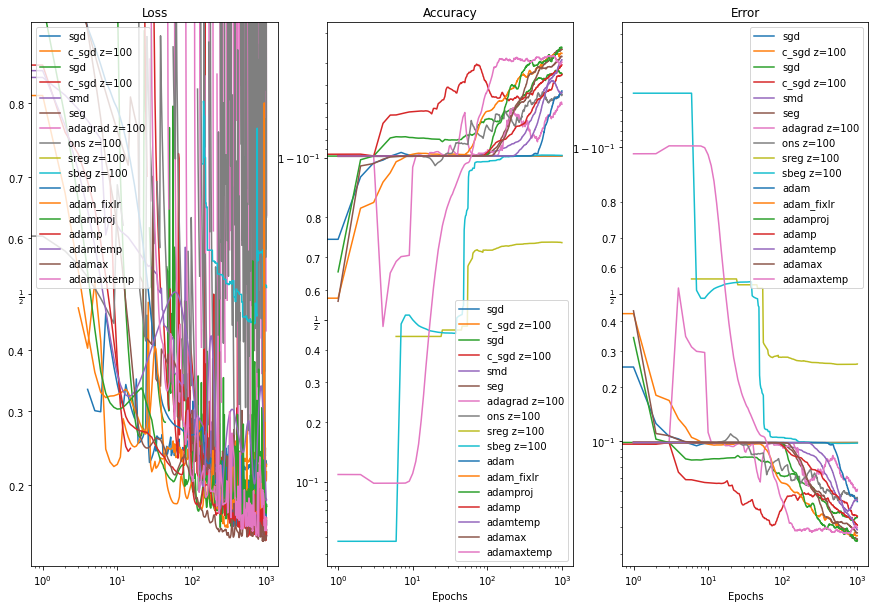

<Figure size 432x288 with 0 Axes>

In [24]:
# Log scale
ax[0].set_xscale('log')
ax[0].set_yscale('logit')
ax[1].set_xscale('log')
ax[1].set_yscale('logit')
ax[2].set_xscale('log')
ax[2].set_yscale('logit')

# legend
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('Error')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[2].set_xlabel('Epochs')


plt.savefig('LossAccuraciesErrors.png')
fig

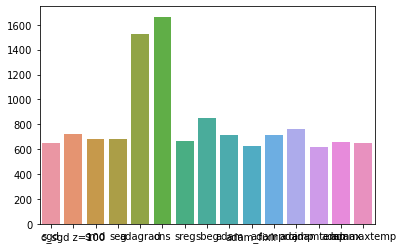

In [25]:
plt.clf()
keys = list(time_dict.keys())
sns.barplot(x=keys, y=[time_dict[k]*20 for k in keys])
plt.savefig('execution_time.png')
plt.show()